# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import zipfile
import cv2
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
!gdown 1quaMis_SfrsuPFWIf2rwyFn1VHWuzvtb

# Configurações
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 12})

# Caminho do arquivo no Drive
zip_path = '/content/archive (1).zip'

# Extrair o conteúdo
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/extracted_content_from_drive')

Downloading...
From (original): https://drive.google.com/uc?id=1quaMis_SfrsuPFWIf2rwyFn1VHWuzvtb
From (redirected): https://drive.google.com/uc?id=1quaMis_SfrsuPFWIf2rwyFn1VHWuzvtb&confirm=t&uuid=d64bdc8e-ec88-47da-88ce-3f79d8215173
To: /content/archive (1).zip
100% 67.6M/67.6M [00:00<00:00, 168MB/s]


# Conhecendo o DataSet
- O Dataset Possui 697 figuras de cães e gatos em resolução variadas que vão de 100x100 a 2000x1000. Logo é necessário fazer um reshape no tamanho da imagem.
- O Dataset também não vem previamente catalogado, sendo necessário um preprocessamento de dados mais aprofundado.

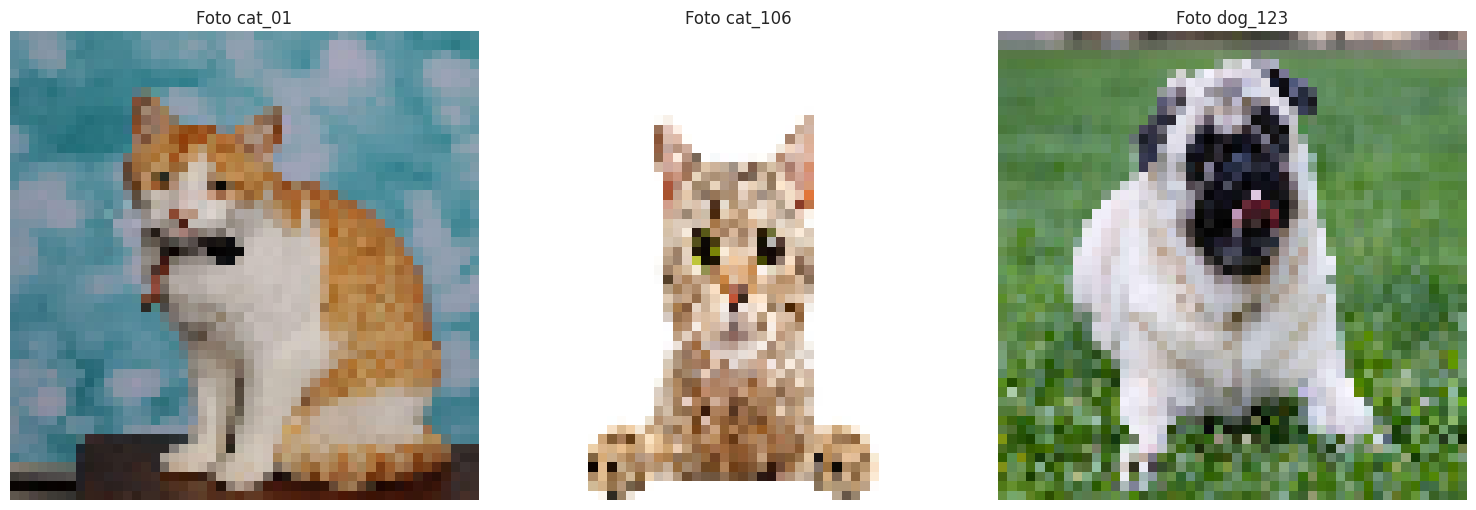

In [2]:
plt.figure(figsize=(15, 15))

plt.subplot(3, 3, 1)
img = cv2.imread('/content/extracted_content_from_drive/test/cats/cat_1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (50,50))
plt.imshow(img)
plt.title(f"Foto cat_01")
plt.axis('off')


plt.subplot(3, 3, 2)
img = cv2.imread('/content/extracted_content_from_drive/test/cats/cat_106.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (50,50))
plt.imshow(img)
plt.title(f"Foto cat_106")
plt.axis('off')



plt.subplot(3, 3, 3)
img = cv2.imread('/content/extracted_content_from_drive/test/dogs/dog_123.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (50,50))
plt.imshow(img)
plt.title(f"Foto dog_123")
plt.axis('off')

plt.tight_layout()
plt.show()

# Tratando os dados

In [75]:
# Função para tratar a imagem
def load_images(folder, label, target_size=(100, 100)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Transformando a imagem em preto e branco
        img = cv2.resize(img, target_size)
        img = img / 255.0  # Normalização
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

########## Pegando dados ##########
# Atribuindo target aos gatos target = 0
X_cat, y_cat = load_images('/content/extracted_content_from_drive/train/cats', 0)

# Atribuindo target aos cachorros target = 1
X_dog, y_dog = load_images('/content/extracted_content_from_drive/train/dogs', 1)

# Atribuindo target aos gatos target = 0
X_cat_teste, y_cat_teste = load_images('/content/extracted_content_from_drive/test/cats', 0)

# Atribuindo target aos cachorros target = 1
X_dog_teste, y_dog_teste = load_images('/content/extracted_content_from_drive/test/dogs', 1)

# Juntando os dados
X_tr  = np.concatenate([X_cat,X_dog])
y_tr  = np.concatenate([y_cat,y_dog])
X_ts  = np.concatenate([X_cat_teste,X_dog_teste])
y_ts = np.concatenate([y_cat_teste,y_dog_teste])

X = np.concatenate([X_tr ,X_ts])
y = np.concatenate([y_tr ,y_ts])
# Separando em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, shuffle = True,test_size = 0.2,stratify=y)
# Separando Validação
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, random_state = 42, shuffle = True,test_size=0.3,stratify=y_train)

In [81]:
pd.Series(y_test).value_counts()

,count
1,70
0,70


In [82]:
print(f'Shapes:\nX_treino{np.shape(X_train)}\ny_treino{np.shape(y_train)}\nX_test{np.shape(X_test)}\ny_test{np.shape(y_test)}')

Shapes:
X_treino(389, 100, 100)
y_treino(389,)
X_test(140, 100, 100)
y_test(140,)


Os nossos dados estão no formato de imagem e precisamos fazer um preprocessamento para ajustar eles. Para fazer isso usamos a biblioteca OpenCV para abrir a imagem e armazenar em formato de array. Diente disso, separamos em treino e teste seguindo uma divisão de 80/20 e 70/30 na validação.

# Criando o modelo

## Parte Convolucional

In [83]:
# Criação do modelo
model = Sequential(name='CNN_cat_dog')

# Bloco Convolucional 1
model.add(Conv2D(filters=32,
                 kernel_size=(5,5),
                 activation='relu',
                 input_shape=(100,100,1)))
model.add(MaxPooling2D(pool_size=(2,2)))

# Bloco Convolucional 2
model.add(Conv2D(filters=64,
                 kernel_size=(5,5),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Bloco Convolucional 3
model.add(Conv2D(filters=128,
                 kernel_size=(5,5),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Parte Densa

In [84]:
# Camadas Densas
model.add(Flatten())
model.add(Dense(2500, activation='relu'))
model.add(Dropout(0.25))  #
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.10))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Saída binária

## Compilando o Modelo
- A configuração de learning rate foi ajustada manualmente até encontrarmos esse valor que foi mais satisfatório pois com outros estavamos ficando em 50% de assertividade nos testes.

In [85]:
# Compilação
import tensorflow
model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "CNN_cat_dog"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)                   │ (None, 96, 96, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 44, 44, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 18, 18, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 2500)                │      25,922,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 2500)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 1024)                │       2,561,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,315,461 (115.64 MB)

 Trainable params: 30,315,461 (115.64 MB)

 Non-trainable params: 0 (0.00 B)

# Treinando o Modelo

In [86]:
# Criando o EarlyStopping para parar automaticamente
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    restore_best_weights=True,
    verbose=1,
    mode='auto'
)

# Treinando o modelo
history = model.fit(X_train,y_train,
    validation_data = (X_validation,y_validation),
    epochs=100,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.4987 - loss: 0.6937 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.5072 - loss: 0.6928 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.4942 - loss: 0.6921 - val_accuracy: 0.5060 - val_loss: 0.6929
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.5171 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6927
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.5063 - loss: 0.6909 - val_accuracy: 0.5000 - val_loss: 0.6928
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.4873 - loss: 0.6924 - val_accuracy: 0.5000 - val_loss: 0.6928
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5243 - loss: 0.6891 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.5060 - loss: 0.6887 - val_accuracy: 0.5060 - v

# Analisando os resultados

## Metricas gerais

In [88]:
y_pred_prob = model.predict(X_test, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int)
print("\n📊 Relatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['Gato', 'Cachorro']))


📊 Relatório de Classificação:
              precision    recall  f1-score   support

        Gato       0.66      0.56      0.60        70
    Cachorro       0.62      0.71      0.66        70

    accuracy                           0.64       140
   macro avg       0.64      0.64      0.63       140
weighted avg       0.64      0.64      0.63       140



## Curva de acurácia e loss

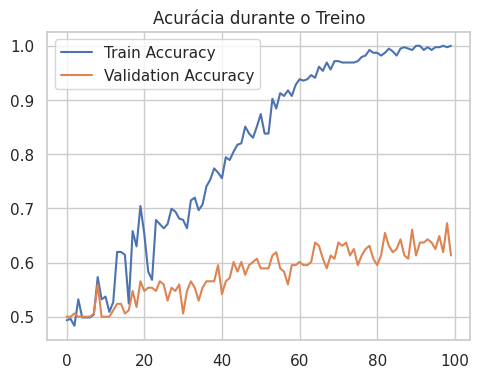

In [93]:
# Plot de acurácia
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Acurácia durante o Treino')
plt.legend()


plt.show()

## Matriz de confusão

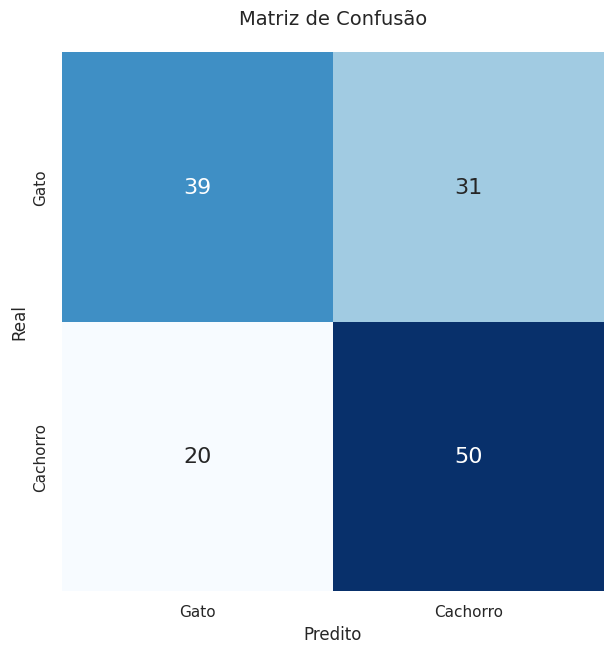

In [90]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            annot_kws={"size": 16}, cbar=False,
            xticklabels=['Gato', 'Cachorro'],
            yticklabels=['Gato', 'Cachorro'])
plt.title('Matriz de Confusão', fontsize=14, pad=20)
plt.xlabel('Predito', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.show()

## Curva ROC

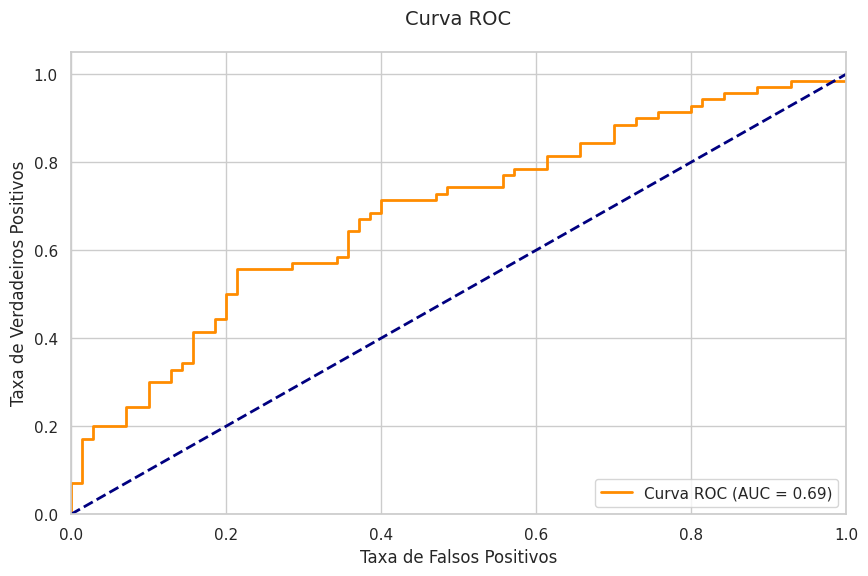

In [91]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
          label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos', fontsize=12)
plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=12)
plt.title('Curva ROC', fontsize=14, pad=20)
plt.legend(loc="lower right")
plt.show()

## Observando resultados

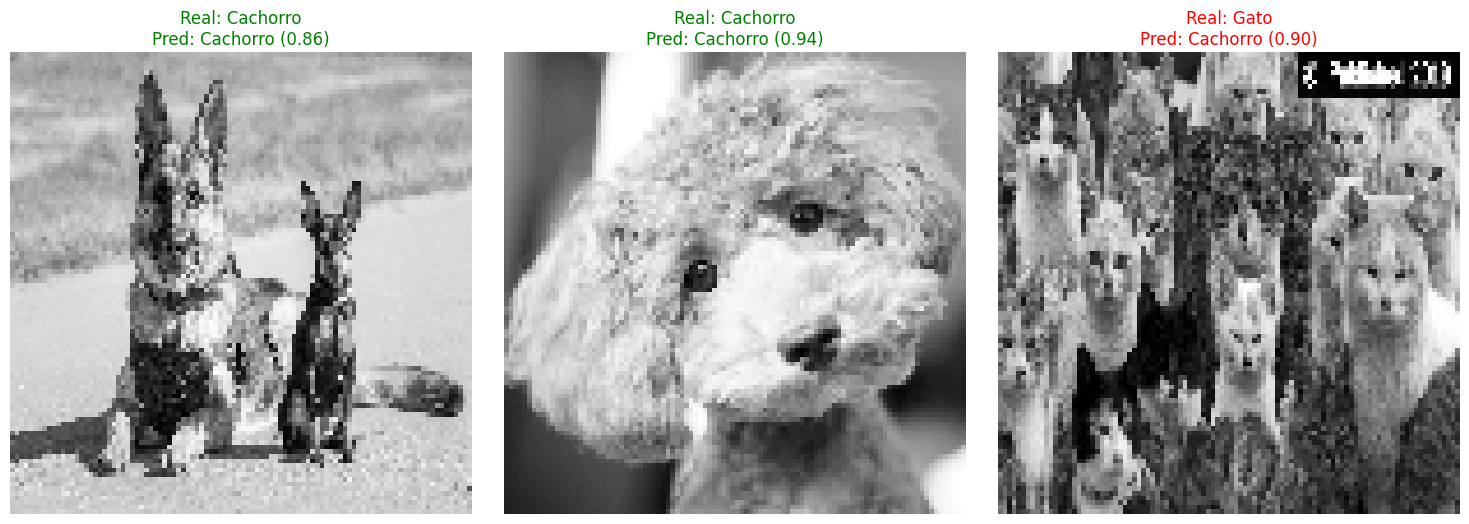

In [92]:
class_names = ['Gato', 'Cachorro']
plt.figure(figsize=(15, 15))

indices = np.random.choice(range(len(X_test)), 3)

for i, idx in enumerate(indices, 1):
    plt.subplot(3, 3, i)
    plt.imshow(X_test[idx], cmap = 'gray')
    true_label = class_names[y_test[idx]]
    pred_label = class_names[y_pred[idx][0]]
    prob = y_pred_prob[idx][0] if pred_label == 'Cachorro' else 1 - y_pred_prob[idx][0]

    color = 'green' if true_label == pred_label else 'red'
    plt.title(f"Real: {true_label}\nPred: {pred_label} ({prob:.2f})", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()